### Image Classification using CNN and transfer learning using freeze/unfreeze layers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re
import pathlib
import random
import tensorflow
from PIL import Image
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

import warnings
warnings.filterwarnings("ignore")

Download the required flower dataset. This dataset has 5 classes (Daisy, Dandelion, Rose, Sunflower, and Tulip). Images for each class are stored in its own folder.

In [ ]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"

dataset_dir = keras.utils.get_file(fname = 'flower_photos' , origin = dataset_url , cache_dir='.',untar=True)


datadir = pathlib.Path(dataset_dir)
datadir

228813984/228813984 [==============================] - 11s 0us/step


PosixPath('datasets/flower_photos')

In [ ]:
# Print the datadir to ensure it's correctly set
print(datadir)

# List all subdirectories in the data directory
subdirectories = [subdir for subdir in datadir.iterdir() if subdir.is_dir()]

print("Subdirectories:")
for subdir in subdirectories:
    print(subdir.name)

datasets/flower_photos
Subdirectories:
daisy
tulips
roses
dandelion
sunflowers


Check the dimensions of random images selected from each subdirectory

Image: datasets/flower_photos/daisy/7454630692_ab2d67dd18_m.jpg, Dimensions: (159, 240)
Image: datasets/flower_photos/tulips/15082212714_ff87e8fcb1_m.jpg, Dimensions: (186, 240)
Image: datasets/flower_photos/roses/5892908233_6756199a43.jpg, Dimensions: (500, 272)
Image: datasets/flower_photos/dandelion/4721773235_429acdf496_n.jpg, Dimensions: (320, 259)
Image: datasets/flower_photos/sunflowers/2442985637_8748180f69.jpg, Dimensions: (386, 320)


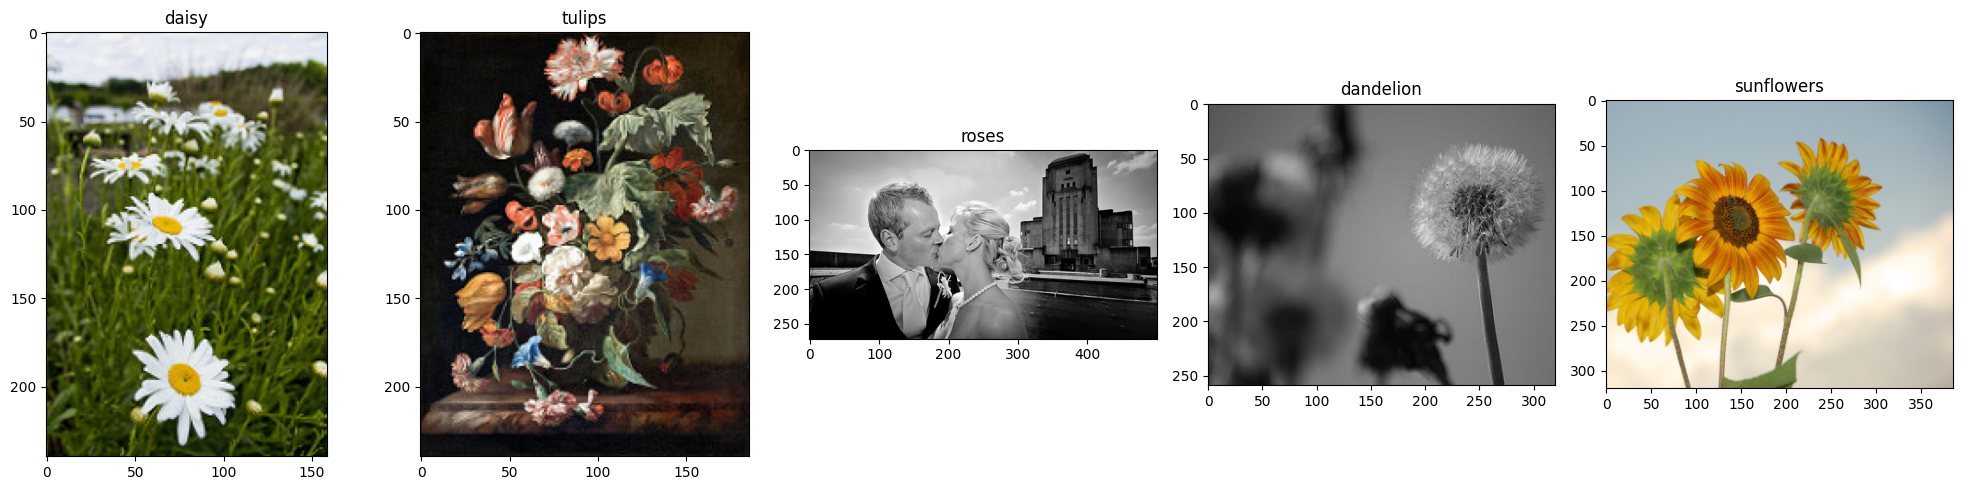

In [ ]:
# Select one random image from each subdirectory and plot it
fig, axes = plt.subplots(1, len(subdirectories), figsize=(20, 5))

for ax, subdir in zip(axes, subdirectories):
    images = list(subdir.glob("*"))
    random_image_path = random.choice(images)
    img = Image.open(random_image_path)
    ax.imshow(img)
    ax.set_title(subdir.name)
    ax.axis('on')
    dimensions = img.size
    print(f"Image: {random_image_path}, Dimensions: {dimensions}")

plt.tight_layout()
plt.show()

As observed, the images have different dimensions. Resize all of them to match the pixel dimensions expected by VGG16, e.g. 224x224 pixels.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resize the image for use by VGG16
resize_image = (224, 224)

#batch size
batch_size=32

# reserve 25% of the training data for validation
rescaled_split = ImageDataGenerator(rescale=1./255, validation_split=0.25)



In [ ]:
# Training and validation sets.
train_data_generator = rescaled_split.flow_from_directory(datadir, target_size=resize_image, batch_size= batch_size, class_mode='categorical', subset='training')

validation_data_generator = rescaled_split.flow_from_directory(datadir, target_size=resize_image, batch_size=batch_size, class_mode='categorical', subset='validation')

Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


Used :

*   Image Data generator and train-test split
*   stratify=Labels for the same distribution of flower types between train and test datasets.



In [ ]:
from itertools import count
import numpy as np
from sklearn.model_selection import train_test_split

# Directory path
data_directory = datadir

# Initialize the ImageDataGenerator with rescaling
data_generator = ImageDataGenerator(rescale=1./255)

# Generate data from the directory without shuffling
generator = data_generator.flow_from_directory(data_directory, target_size=resize_image, batch_size=1, class_mode='categorical', shuffle=False)

# Extract filepaths and labels from the generator
filepaths = generator.filepaths
labels = generator.labels

# Split the data into training and testing sets with stratification
train_files, test_files, train_labels, test_labels = train_test_split(filepaths, labels, test_size=0.2, stratify=labels, random_state=42)

# The training and testing sets
(train_files, train_labels), (test_files, test_labels)



Found 3670 images belonging to 5 classes.


((['datasets/flower_photos/roses/15738649506_2b4c2fd933_m.jpg',
   'datasets/flower_photos/dandelion/13897156242_dca5d93075_m.jpg',
   'datasets/flower_photos/roses/16152205512_9d6cb80fb6.jpg',
   'datasets/flower_photos/roses/12406418663_af20dc225f_n.jpg',
   'datasets/flower_photos/roses/5863698305_04a4277401_n.jpg',
   'datasets/flower_photos/daisy/2621723097_736febb4a4_n.jpg',
   'datasets/flower_photos/sunflowers/22429146402_332fa2fc72_m.jpg',
   'datasets/flower_photos/roses/7419966772_d6c1c22a81.jpg',
   'datasets/flower_photos/sunflowers/13096076565_72c2c60875_n.jpg',
   'datasets/flower_photos/tulips/17078576150_6f272ce73f_n.jpg',
   'datasets/flower_photos/tulips/14022473102_3b24ca08cb_m.jpg',
   'datasets/flower_photos/tulips/2431737309_1468526f8b.jpg',
   'datasets/flower_photos/dandelion/2661585172_94707236be_m.jpg',
   'datasets/flower_photos/roses/12323085443_8ac0cdb713_n.jpg',
   'datasets/flower_photos/roses/5990626258_697f007308_n.jpg',
   'datasets/flower_photos/tuli

Use a VGG16 model (pre-trained on ImageNet) for transfer learning. Remove the top layers (fully connected layers).Add your own fully connected layers (example: one with 256 nodes using ‘relu’ activation, and an output layer with 5 nodes and ‘softmax’ activation; the choice is up to you). You will train three different models and compare all three:

### Base Model: VGG16 model (pre-trained on ImageNet) for transfer learning. Remove the top layers (fully connected layers).

In [ ]:
image_w, image_h = 224, 224
Base_model = tensorflow.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
Base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Exp 1: Freeze all layers in the base model

In [ ]:
# Freeze all layers in the base model
for layer in Base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model1 = Sequential([
        Base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(5, activation='softmax')
    ])

model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history1 = model1.fit(train_data_generator,
                      epochs=10,
                      validation_data=validation_data_generator)

Epoch 1/10
87/87 [==============================] - 14s 110ms/step - loss: 0.8127 - accuracy: 0.7045 - val_loss: 0.6591 - val_accuracy: 0.7541
Epoch 2/10
87/87 [==============================] - 8s 94ms/step - loss: 0.3547 - accuracy: 0.8838 - val_loss: 0.5728 - val_accuracy: 0.8087
Epoch 3/10
87/87 [==============================] - 8s 91ms/step - loss: 0.2098 - accuracy: 0.9481 - val_loss: 0.6368 - val_accuracy: 0.7727
Epoch 4/10
87/87 [==============================] - 8s 95ms/step - loss: 0.1283 - accuracy: 0.9764 - val_loss: 0.5357 - val_accuracy: 0.8044
Epoch 5/10
87/87 [==============================] - 8s 95ms/step - loss: 0.0875 - accuracy: 0.9895 - val_loss: 0.5576 - val_accuracy: 0.8098
Epoch 6/10
87/87 [==============================] - 8s 95ms/step - loss: 0.0581 - accuracy: 0.9982 - val_loss: 0.5840 - val_accuracy: 0.8120
Epoch 7/10
87/87 [==============================] - 8s 95ms/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.5408 - val_accuracy: 0.8186
Epoch 8/10


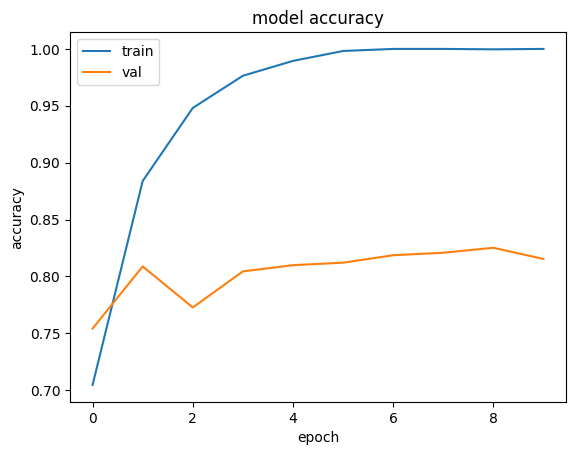

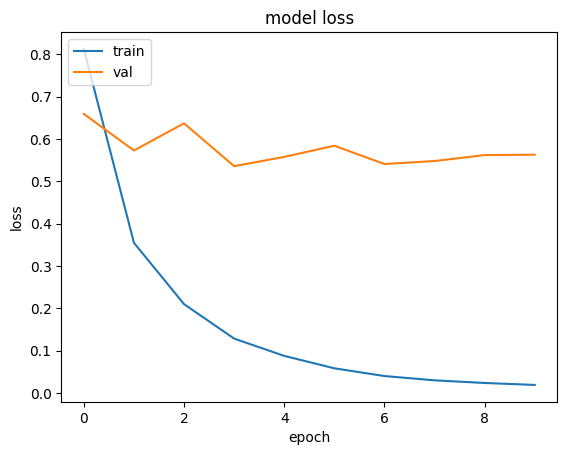

In [ ]:
def plot_learning_curves(history):

  # plot curves for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_learning_curves(history1)

## Exp 1 + hyperparameter tuning with Number of neurons and additional layer

In [ ]:
# Add more neurons and an additional layer
model1_neurons = Sequential([
    Base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

model1_neurons.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history2 = model1_neurons.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 10s 102ms/step - loss: 0.8722 - accuracy: 0.6640 - val_loss: 0.6472 - val_accuracy: 0.7701 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 0.3870 - accuracy: 0.8704 - val_loss: 0.5950 - val_accuracy: 0.7846 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 96ms/step - loss: 0.2202 - accuracy: 0.9365 - val_loss: 0.5989 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 96ms/step - loss: 0.1237 - accuracy: 0.9703 - val_loss: 0.5606 - val_accuracy: 0.8002 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 8s 96ms/step - loss: 0.0581 - accuracy: 0.9934 - val_loss: 0.5769 - val_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 95ms/step - loss: 0.0306 - accuracy: 0.9993 - val_loss: 0.5760 - val_accuracy: 0.8181 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] 

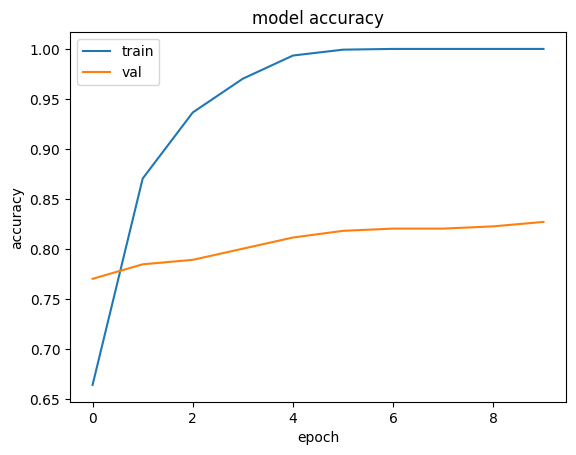

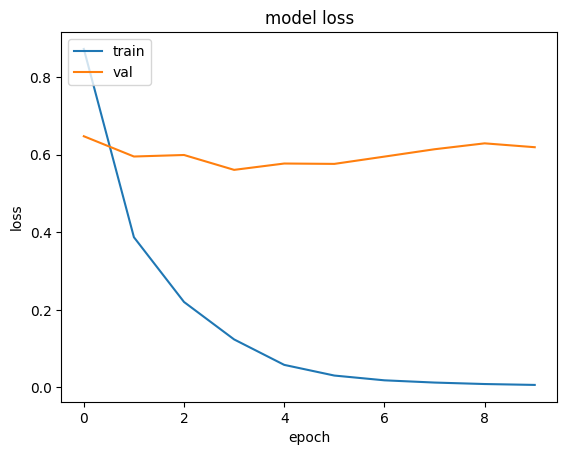

In [ ]:
plot_learning_curves(history2)

## Exp 1 + hyperparameter tuning with SGD optimiser

In [ ]:
# Option 2: Different Optimizer

# Use SGD optimizer with momentum
model1_optimizer = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

model1_optimizer.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model1_optimizer.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 10s 101ms/step - loss: 1.4428 - accuracy: 0.4308 - val_loss: 1.1941 - val_accuracy: 0.5792 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 96ms/step - loss: 1.0211 - accuracy: 0.6541 - val_loss: 0.9922 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.8583 - accuracy: 0.7246 - val_loss: 0.9073 - val_accuracy: 0.6853 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 94ms/step - loss: 0.7715 - accuracy: 0.7517 - val_loss: 0.8390 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 8s 92ms/step - loss: 0.7020 - accuracy: 0.7716 - val_loss: 0.7988 - val_accuracy: 0.7076 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 93ms/step - loss: 0.6606 - accuracy: 0.7903 - val_loss: 0.8363 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] 

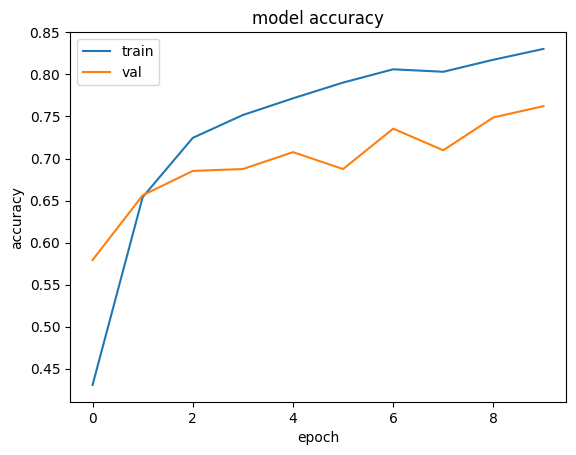

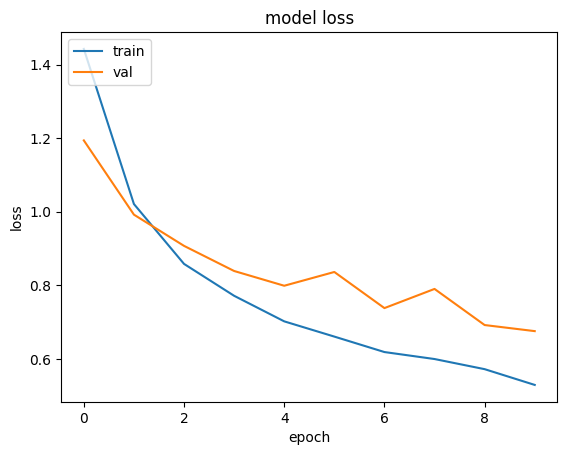

In [ ]:
plot_learning_curves(history3)

Exp 1 + hyperparameter tuning with L2 Regularisation

In [ ]:
# Option 3: L2 Regularization

from tensorflow.keras.regularizers import l2

# Add L2 regularization to dense layers
model1_regularization = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(5, activation='softmax')
])

model1_regularization.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history4 = model1_regularization.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 10s 99ms/step - loss: 4.6206 - accuracy: 0.6779 - val_loss: 3.5066 - val_accuracy: 0.7612 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 2.7428 - accuracy: 0.8773 - val_loss: 2.6042 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 93ms/step - loss: 2.0295 - accuracy: 0.9299 - val_loss: 2.1430 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 94ms/step - loss: 1.6093 - accuracy: 0.9497 - val_loss: 1.8466 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 8s 94ms/step - loss: 1.3248 - accuracy: 0.9651 - val_loss: 1.5898 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 93ms/step - loss: 1.0898 - accuracy: 0.9875 - val_loss: 1.4404 - val_accuracy: 0.8170 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] -

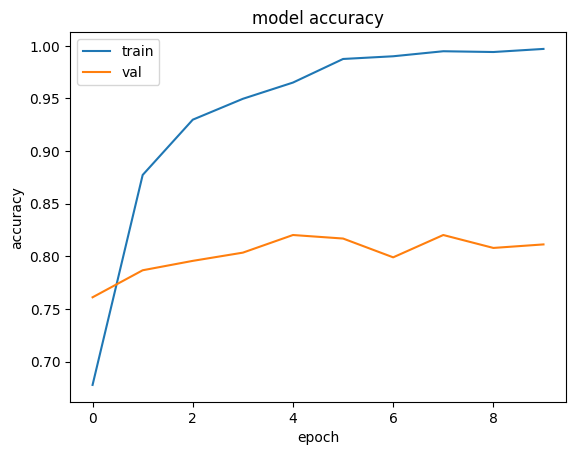

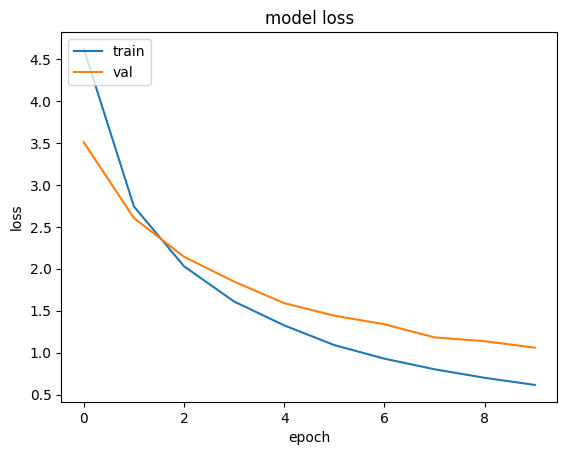

In [ ]:
plot_learning_curves(history4)

## Exp 1 + hyperparameter tuning with batch normalisation and drop out

In [ ]:
# Add batch normalization and dropout
model1_BN_D = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

model1_BN_D.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model1_BN_D.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 11s 102ms/step - loss: 1.0305 - accuracy: 0.6658 - val_loss: 0.8048 - val_accuracy: 0.7087 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 0.4493 - accuracy: 0.8450 - val_loss: 0.6545 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.2880 - accuracy: 0.9064 - val_loss: 0.6027 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 93ms/step - loss: 0.1926 - accuracy: 0.9365 - val_loss: 0.5793 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 8s 93ms/step - loss: 0.1460 - accuracy: 0.9559 - val_loss: 0.6415 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 94ms/step - loss: 0.1175 - accuracy: 0.9680 - val_loss: 0.7020 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] 

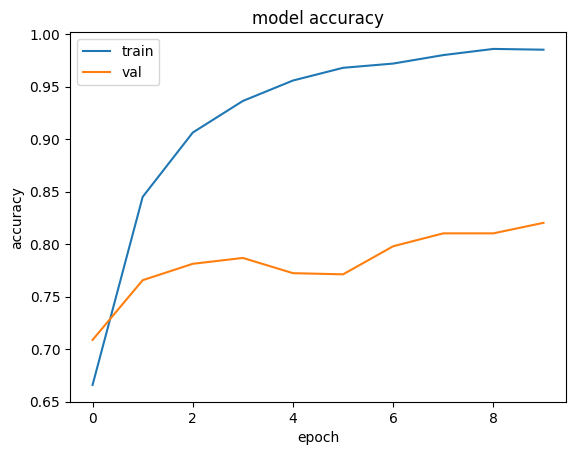

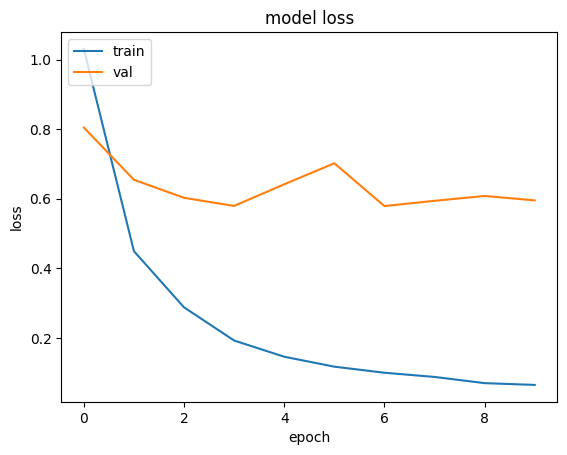

In [ ]:
plot_learning_curves(history5)

## Exp 1 + hyperparameter tuning with data augumentation

In [ ]:

# Enhanced data augmentation settings

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    data_directory,
    target_size=resize_image,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator_aug = train_datagen_aug.flow_from_directory(
    data_directory,
    target_size=resize_image,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model1_dataaug = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

model1_dataaug.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history6 = model1_dataaug.fit(
    train_generator_aug,
    steps_per_epoch=train_generator_aug.samples // train_generator_aug.batch_size,
    validation_data=validation_generator_aug,
    validation_steps=validation_generator_aug.samples // validation_generator_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Epoch 1/10
91/91 [==============================] - 45s 480ms/step - loss: 1.0246 - accuracy: 0.6010 - val_loss: 0.8707 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 2/10
91/91 [==============================] - 43s 472ms/step - loss: 0.7372 - accuracy: 0.7344 - val_loss: 0.7450 - val_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 3/10
91/91 [==============================] - 43s 473ms/step - loss: 0.7002 - accuracy: 0.7427 - val_loss: 0.8797 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 4/10
91/91 [==============================] - 43s 471ms/step - loss: 0.6348 - accuracy: 0.7630 - val_loss: 0.8065 - val_accuracy: 0.6918 - lr: 1.0000e-04
Epoch 5/10
91/91 [==============================] - 43s 474ms/step - loss: 0.6008 - accuracy: 0.7785 - val_loss: 0.6512 - val_accuracy: 0.7528 - lr: 1.0000e-04
Epoch 6/10
91/91 [==============================] - 43s 474ms/step - loss: 0.5824 - accuracy: 0.7881 - val_loss: 0.63

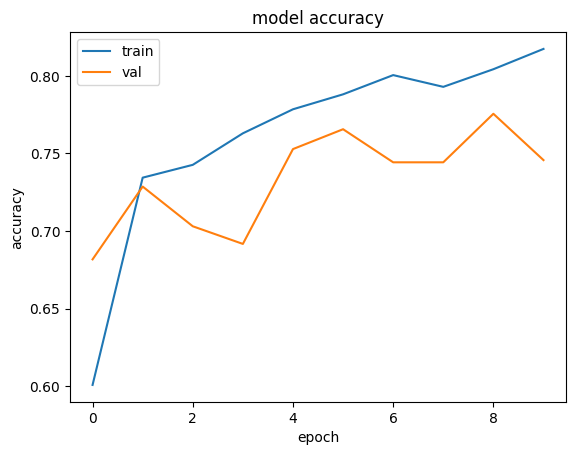

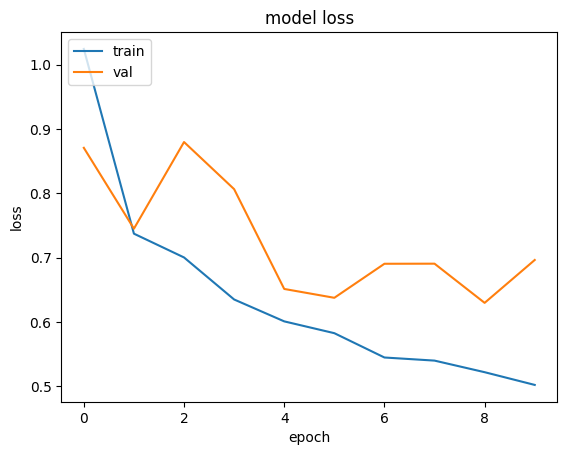

In [ ]:
plot_learning_curves(history6)

## Exp 1 + Best hyperparameters selected (batch normalisation, drop out, data augumentation)

In [ ]:
#optimised
model1_optimised = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

model1_optimised.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history7 = model1_optimised.fit(
    train_generator_aug,
    steps_per_epoch=train_generator_aug.samples // train_generator_aug.batch_size,
    validation_data=validation_generator_aug,
    validation_steps=validation_generator_aug.samples // validation_generator_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
91/91 [==============================] - 45s 476ms/step - loss: 1.2568 - accuracy: 0.5721 - val_loss: 0.9544 - val_accuracy: 0.6108 - lr: 1.0000e-04
Epoch 2/10
91/91 [==============================] - 43s 474ms/step - loss: 0.9233 - accuracy: 0.6715 - val_loss: 0.7766 - val_accuracy: 0.7102 - lr: 1.0000e-04
Epoch 3/10
91/91 [==============================] - 43s 473ms/step - loss: 0.8242 - accuracy: 0.7097 - val_loss: 0.8337 - val_accuracy: 0.7003 - lr: 1.0000e-04
Epoch 4/10
91/91 [==============================] - 43s 473ms/step - loss: 0.7748 - accuracy: 0.7279 - val_loss: 0.7396 - val_accuracy: 0.7443 - lr: 1.0000e-04
Epoch 5/10
91/91 [==============================] - 43s 472ms/step - loss: 0.7125 - accuracy: 0.7461 - val_loss: 0.7645 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 6/10
91/91 [==============================] - 43s 473ms/step - loss: 0.7294 - accuracy: 0.7437 - val_loss: 0.6540 - val_accuracy: 0.7557 - lr: 1.0000e-04
Epoch 7/10
91/91 [======================

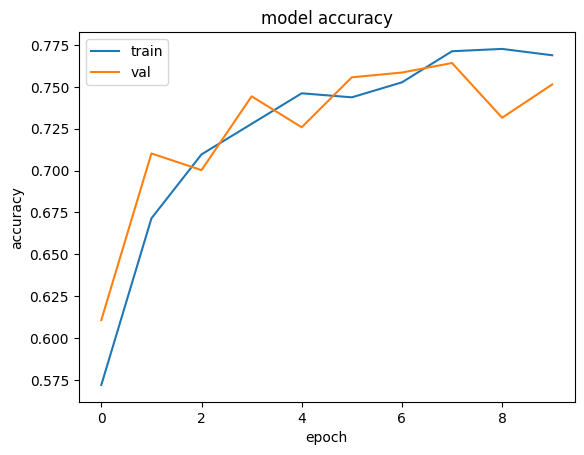

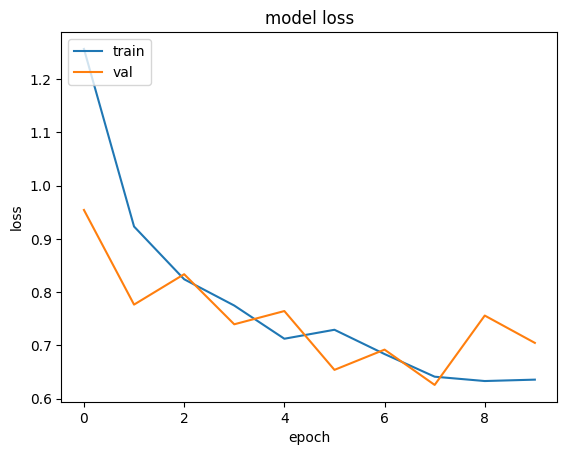

In [ ]:
plot_learning_curves(history7)

In [ ]:
image_w, image_h = 224, 224
Base_model = tensorflow.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
Base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Model 2: Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model.

## Best hyperparameters used: Batch normalisation, drop out, data augumentation


In [ ]:
# Freeze layers up to block4_pool
for layer in Base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(Base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


## MODEL 2: unfreeze the last block of VGG16 (block5)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

MODEL2 = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

MODEL2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_model2 = MODEL2.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 11s 103ms/step - loss: 0.8834 - accuracy: 0.6985 - val_loss: 0.5993 - val_accuracy: 0.7734 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 95ms/step - loss: 0.3332 - accuracy: 0.8825 - val_loss: 0.7248 - val_accuracy: 0.7679 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.1716 - accuracy: 0.9412 - val_loss: 0.5549 - val_accuracy: 0.8170 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 93ms/step - loss: 0.0957 - accuracy: 0.9658 - val_loss: 0.7198 - val_accuracy: 0.7801 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 8s 95ms/step - loss: 0.0518 - accuracy: 0.9849 - val_loss: 0.4601 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 94ms/step - loss: 0.0277 - accuracy: 0.9930 - val_loss: 0.4081 - val_accuracy: 0.8627 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] 

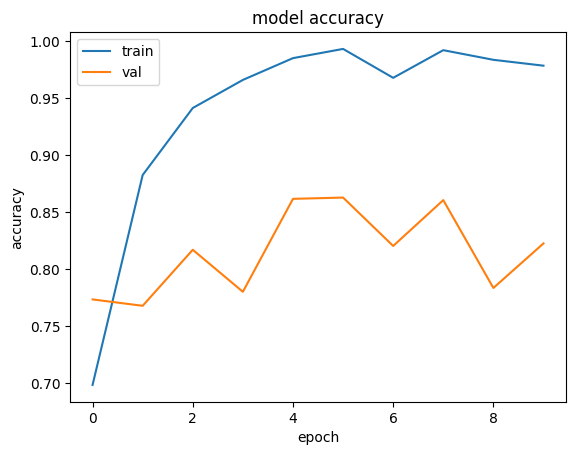

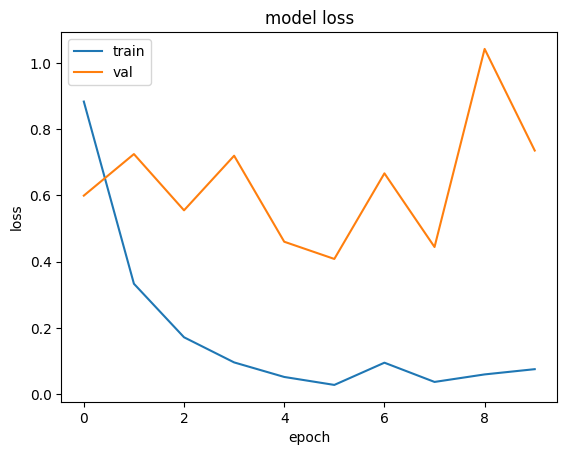

In [ ]:
plot_learning_curves(history_model2)

### MODEL 2aug: unfreeze the last block of VGG16 (block5) + hyperparameters (Batch norm, Drop out, data aug) used


In [ ]:
MODEL2aug = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

MODEL2aug.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_model2aug = MODEL2aug.fit(
    train_generator_aug,
    steps_per_epoch=train_generator_aug.samples // train_generator_aug.batch_size,
    validation_data=validation_generator_aug,
    validation_steps=validation_generator_aug.samples // validation_generator_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
91/91 [==============================] - 45s 473ms/step - loss: 0.6859 - accuracy: 0.7661 - val_loss: 0.5475 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 2/10
91/91 [==============================] - 43s 472ms/step - loss: 0.4542 - accuracy: 0.8411 - val_loss: 0.4849 - val_accuracy: 0.8295 - lr: 1.0000e-04
Epoch 3/10
91/91 [==============================] - 43s 471ms/step - loss: 0.3894 - accuracy: 0.8603 - val_loss: 0.6195 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 4/10
91/91 [==============================] - 43s 471ms/step - loss: 0.3231 - accuracy: 0.8851 - val_loss: 0.5612 - val_accuracy: 0.8253 - lr: 1.0000e-04
Epoch 5/10
91/91 [==============================] - 43s 473ms/step - loss: 0.3220 - accuracy: 0.8827 - val_loss: 0.4841 - val_accuracy: 0.8381 - lr: 1.0000e-04
Epoch 6/10
91/91 [==============================] - 43s 472ms/step - loss: 0.2809 - accuracy: 0.9006 - val_loss: 0.6335 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 7/10
91/91 [======================

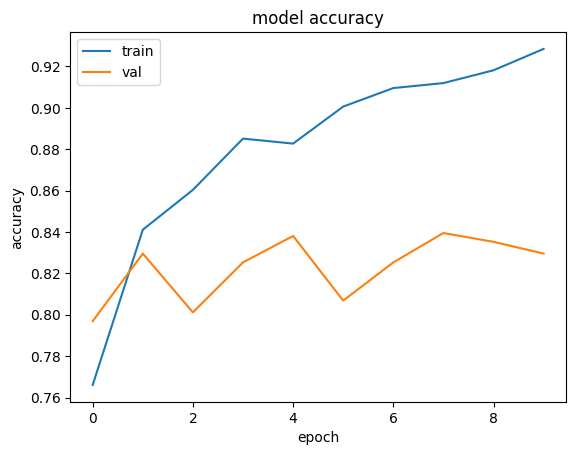

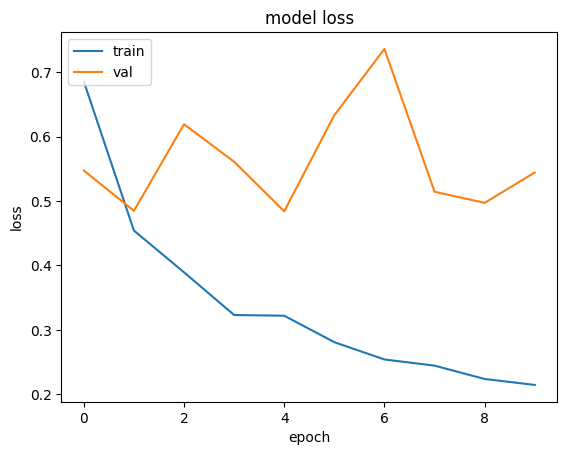

In [ ]:
plot_learning_curves(history_model2aug)

## Model 3: Third, unfreeze all the layers and try again. Evaluate your model.

In [ ]:
# Unfreeze all layers
for layer in Base_model.layers:
    layer.trainable = True

In [ ]:
for i, layer in enumerate(Base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
#MODEL_3
MODEL3 = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

MODEL3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_model3 = MODEL3.fit(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // validation_data_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
86/86 [==============================] - 17s 106ms/step - loss: 0.6447 - accuracy: 0.7804 - val_loss: 0.6955 - val_accuracy: 0.8013 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 0.3982 - accuracy: 0.8696 - val_loss: 0.7303 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 8s 94ms/step - loss: 0.3373 - accuracy: 0.8781 - val_loss: 0.8595 - val_accuracy: 0.7433 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 8s 94ms/step - loss: 0.1622 - accuracy: 0.9427 - val_loss: 0.5371 - val_accuracy: 0.8304 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 9s 98ms/step - loss: 0.1325 - accuracy: 0.9530 - val_loss: 0.4359 - val_accuracy: 0.8605 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 8s 96ms/step - loss: 0.0859 - accuracy: 0.9710 - val_loss: 0.3784 - val_accuracy: 0.8739 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] 

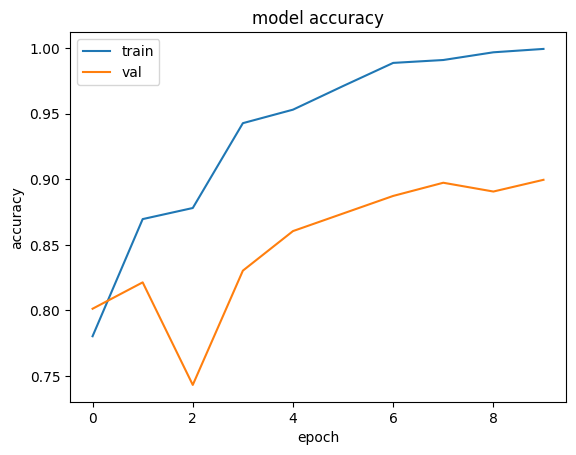

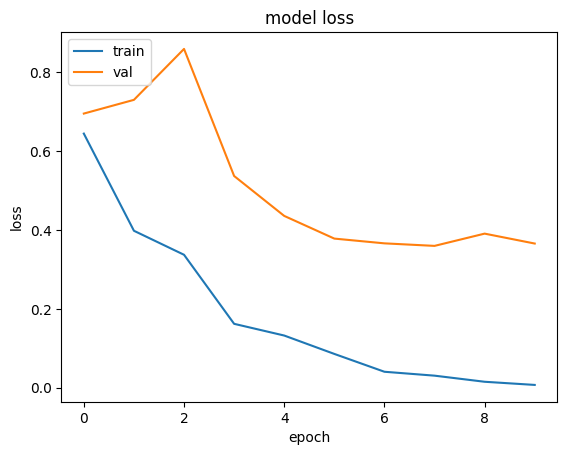

In [ ]:
plot_learning_curves(history_model3)

### Model 3aug: unfreeze all the layers + hyperparameters (batch norm, dropout, data aug)

In [ ]:
MODEL3aug = Sequential([
    Base_model,
    Flatten(),
    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(5, activation='softmax')
])

MODEL3aug.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_model3aug = MODEL3aug.fit(
    train_generator_aug,
    steps_per_epoch=train_generator_aug.samples // train_generator_aug.batch_size,
    validation_data=validation_generator_aug,
    validation_steps=validation_generator_aug.samples // validation_generator_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
91/91 [==============================] - 50s 504ms/step - loss: 0.5379 - accuracy: 0.8115 - val_loss: 0.9406 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 2/10
91/91 [==============================] - 43s 472ms/step - loss: 0.3350 - accuracy: 0.8858 - val_loss: 0.6033 - val_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 3/10
91/91 [==============================] - 43s 473ms/step - loss: 0.3183 - accuracy: 0.8810 - val_loss: 0.8281 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 4/10
91/91 [==============================] - 43s 473ms/step - loss: 0.3439 - accuracy: 0.8824 - val_loss: 0.4455 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 5/10
91/91 [==============================] - 43s 472ms/step - loss: 0.3125 - accuracy: 0.8851 - val_loss: 0.5206 - val_accuracy: 0.8352 - lr: 1.0000e-04
Epoch 6/10
91/91 [==============================] - 43s 473ms/step - loss: 0.2190 - accuracy: 0.9205 - val_loss: 0.5284 - val_accuracy: 0.8295 - lr: 1.0000e-04
Epoch 7/10
91/91 [======================

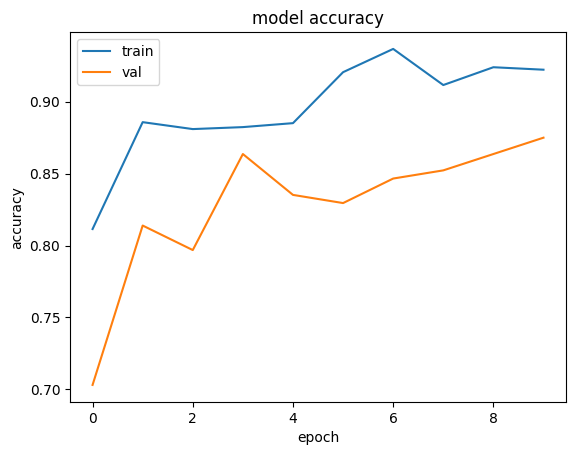

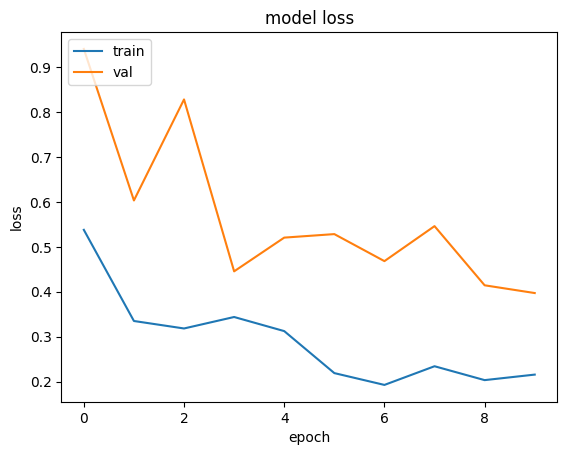

In [ ]:
plot_learning_curves(history_model3aug)

## Evaluation on test dataset

In [ ]:
# Evaluate on Test Set:

def evaluate_model(model, test_files, test_labels):
    test_gen = rescaled_split.flow_from_directory(
        datadir,
        target_size=resize_image,
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return model.evaluate(test_gen)


test_results1 = evaluate_model(model1, test_files, test_labels) #VGG
test_results2 = evaluate_model(model1_neurons, test_files, test_labels) # number of neurons
test_results3 = evaluate_model(model1_optimizer, test_files, test_labels)
test_results4 = evaluate_model(model1_regularization, test_files, test_labels)
test_results5 = evaluate_model(model1_BN_D, test_files, test_labels)
test_results6 = evaluate_model(model1_dataaug, test_files, test_labels)
test_results7 = evaluate_model(model1_optimised, test_files, test_labels)
test_results8 = evaluate_model(MODEL2, test_files, test_labels)
test_results9 = evaluate_model(MODEL2aug, test_files, test_labels)
test_results10 = evaluate_model(MODEL3, test_files, test_labels)
test_results11 = evaluate_model(MODEL3aug, test_files, test_labels)


print(f'model1 Test Accuracy: {test_results1[1]}')
print(f'model1_neurons Test Accuracy: {test_results2[1]}')
print(f'model1_optimizer Test Accuracy: {test_results3[1]}')
print(f'model1_regularization Test Accuracy: {test_results4[1]}')
print(f'model1_BN_D Test Accuracy: {test_results5[1]}')
print(f'model1_dataaug Test Accuracy: {test_results6[1]}')
print(f'model1_optimised Test Accuracy: {test_results7[1]}')
print(f'MODEL2 Test Accuracy: {test_results8[1]}')
print(f'MODEL2aug Test Accuracy: {test_results9[1]}')
print(f'MODEL3 Test Accuracy: {test_results10[1]}')
print(f'MODEL3aug Test Accuracy: {test_results11[1]}')


Found 3670 images belonging to 5 classes.
115/115 [==============================] - 9s 77ms/step - loss: 0.1514 - accuracy: 0.9540
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 70ms/step - loss: 0.1582 - accuracy: 0.9569
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 69ms/step - loss: 0.5468 - accuracy: 0.8275
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 71ms/step - loss: 0.6849 - accuracy: 0.9529
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 70ms/step - loss: 0.1598 - accuracy: 0.9545
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 70ms/step - loss: 0.3895 - accuracy: 0.8572
Found 3670 images belonging to 5 classes.
115/115 [==============================] - 8s 71ms/step - loss: 0.4093 - accuracy: 0.8550
Found 3670 images belonging to 5 classes.
115/115 [=========================